<a href="https://colab.research.google.com/github/SophyyCC/GEOG761-Project/blob/main/RF_code_v1_no_soil_moisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Christchurch 2011 Liquefaction Prediction - Real Data Only
# Using: Liquefaction obs, groundwater depth, DEM, PGA, Vs30, rivers, coastline, soil moisture

# ============================================================================
# CELL 1: Install Required Packages
# ============================================================================
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install --upgrade rasterio geopandas scikit-learn imbalanced-learn scipy
!pip install --upgrade tensorflow requests matplotlib seaborn joblib
!pip install pyproj
!apt-get install -qq gdal-bin python3-gdal

print("✓ All packages installed successfully!")
print("⚠️  IMPORTANT: Now go to Runtime → Restart runtime, then run Cell 2")

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 96.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 100.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting unin

Selecting previously unselected package python3-numpy.
(Reading database ... 126718 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.21.5-1ubuntu22.04.1_amd64.deb ...
Unpacking python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Selecting previously unselected package python3-gdal.
Preparing to unpack .../python3-gdal_3.8.4+dfsg-1~jammy0_amd64.deb ...
Unpacking python3-gdal (3.8.4+dfsg-1~jammy0) ...
Selecting previously unselected package gdal-bin.
Preparing to unpack .../gdal-bin_3.8.4+dfsg-1~jammy0_amd64.deb ...
Unpacking gdal-bin (3.8.4+dfsg-1~jammy0) ...
Setting up python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Setting up python3-gdal (3.8.4+dfsg-1~jammy0) ...
Setting up gdal-bin (3.8.4+dfsg-1~jammy0) ...
Processing triggers for man-db (2.10.2-1) ...
✓ All packages installed successfully!
⚠️  IMPORTANT: Now go to Runtime → Restart runtime, then run Cell 2


In [1]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import warnings
warnings.filterwarnings('ignore')

# ML imports
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("✓ Libraries imported successfully!")

# ============================================================================
# CELL 3: Configuration and Setup
# ============================================================================

# Study area bounds (Christchurch)
CHRISTCHURCH_BOUNDS = {
    'west': 172.50,
    'south': -43.60,
    'east': 172.80,
    'north': -43.45
}

# NZTM2000 bounds (approximate)
NZTM_BOUNDS = {
    'west': 1560000,
    'south': 5170000,
    'east': 1585000,
    'north': 5190000
}

CELL_SIZE = 25  # meters
TARGET_CRS = 'EPSG:2193'  # NZTM2000

# Create output directories
os.makedirs('data/processed', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

print(f"✓ Configuration:")
print(f"  Grid resolution: {CELL_SIZE}m")
print(f"  Target CRS: {TARGET_CRS}")

TensorFlow version: 2.20.0
✓ Libraries imported successfully!
✓ Configuration:
  Grid resolution: 25m
  Target CRS: EPSG:2193


In [7]:

# ============================================================================
# CELL 4: Define File Paths (Based on Uploaded Structure)
# ============================================================================

print("\n" + "="*60)
print("SETTING FILE PATHS")
print("="*60)

# Define exact file paths based on your upload structure
FILE_PATHS = {
    'vs30': '_ags_VS30_extract.zip/zipfolder/vs30_mosaic',
    'dem': 'DEM_rasters_SRTMGL1.tar.gz/output_SRTMGL1',
    'groundwater': 'Depth_To_Groundwater.zip/Depth_To_Groundwater.shp',
    'coastline': 'lds-nz-coastlines-and-islands-polygons-topo-150k-SHP.zip/lds-nz-coastlines-and-islands-polygons-topo-150k.shp',
    'liquefaction': 'Mapped_Liquefaction_-_Feb_2011.zip/Mapped_Liquefaction_-_Feb_2011.shp',
    'rivers': 'rivers_lds-new-zealand-2layers-SHP.zip/nz-river-polygons-topo-150k/nz-river-polygons-topo-150k.shp',
    'pga': 'pga_g.tif'
}

# Verify all files exist
print("\nVerifying files:")
all_exist = True
for name, path in FILE_PATHS.items():
    if os.path.exists(path):
        print(f"  ✓ {name:15s}: {path}")
    else:
        print(f"  ✗ {name:15s}: {path} NOT FOUND")
        all_exist = False

        # Try to find the file
        print(f"    Searching for {name}...")
        import glob

        # Search patterns based on file type
        if name == 'vs30':
            patterns = ['**/vs30*.tif', '**/VS30*.tif', 'vs30*.tif']
        elif name == 'dem':
            patterns = ['**/output*.tif', '**/SRTM*.tif', 'output*.tif', '*DEM*.tif']
        elif name == 'pga':
            patterns = ['**/pga*.tif', 'pga*.tif', '**/PGA*.tif']
        elif name == 'groundwater':
            patterns = ['**/Depth*.shp', '**/depth*.shp', 'Depth*.shp', '**/groundwater*.shp']
        elif name == 'liquefaction':
            patterns = ['**/Mapped*.shp', '**/liquefaction*.shp', 'Mapped*.shp']
        elif name == 'rivers':
            patterns = ['**/nz-river*.shp', '**/river*.shp', 'nz-river*.shp']
        elif name == 'coastline':
            patterns = ['**/lds-nz-coast*.shp', '**/coast*.shp', 'lds-nz-coast*.shp']

        found_files = []
        for pattern in patterns:
            found_files.extend(glob.glob(pattern, recursive=True))

        if found_files:
            print(f"    Found alternatives: {found_files}")
            FILE_PATHS[name] = found_files[0]
            print(f"    Using: {found_files[0]}")
            all_exist = True

if not all_exist:
    print("\n" + "="*60)
    print("⚠️  SOME FILES NOT FOUND")
    print("="*60)
    print("\nListing all files in current directory:")

    import glob
    all_files = glob.glob('**/*', recursive=True)
    tif_files = [f for f in all_files if f.endswith(('.tif', '.TIF'))]
    shp_files = [f for f in all_files if f.endswith('.shp')]

    print(f"\nTIF files ({len(tif_files)}):")
    for f in tif_files[:20]:  # Show first 20
        print(f"  {f}")

    print(f"\nShapefiles ({len(shp_files)}):")
    for f in shp_files[:20]:  # Show first 20
        print(f"  {f}")

    print("\nPlease update FILE_PATHS dictionary in Cell 4 with correct paths")
    raise FileNotFoundError("Some required files not found")

print("\n" + "="*60)
print("✓ ALL FILES VERIFIED")
print("="*60)

# Show file sizes for verification
print("\nFile information:")
for name, path in FILE_PATHS.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024*1024)
        print(f"  {name:15s}: {size_mb:6.1f} MB - {path}")

print("\n✓ Ready to process data!")



SETTING FILE PATHS

Verifying files:
  ✗ vs30           : _ags_VS30_extract.zip/zipfolder/vs30_mosaic NOT FOUND
    Searching for vs30...
  ✗ dem            : DEM_rasters_SRTMGL1.tar.gz/output_SRTMGL1 NOT FOUND
    Searching for dem...
  ✗ groundwater    : Depth_To_Groundwater.zip/Depth_To_Groundwater.shp NOT FOUND
    Searching for groundwater...
  ✗ coastline      : lds-nz-coastlines-and-islands-polygons-topo-150k-SHP.zip/lds-nz-coastlines-and-islands-polygons-topo-150k.shp NOT FOUND
    Searching for coastline...
  ✗ liquefaction   : Mapped_Liquefaction_-_Feb_2011.zip/Mapped_Liquefaction_-_Feb_2011.shp NOT FOUND
    Searching for liquefaction...
  ✗ rivers         : rivers_lds-new-zealand-2layers-SHP.zip/nz-river-polygons-topo-150k/nz-river-polygons-topo-150k.shp NOT FOUND
    Searching for rivers...
  ✓ pga            : pga_g.tif

⚠️  SOME FILES NOT FOUND

Listing all files in current directory:

TIF files (1):
  pga_g.tif

Shapefiles (0):

Please update FILE_PATHS dictionary in C

FileNotFoundError: Some required files not found

In [13]:
# ============================================================================
# CELL 0: Upload Data Files (Run this first!)
# ============================================================================

print("="*60)
print("DATA UPLOAD WIZARD")
print("="*60)
print("\nThis cell will guide you through uploading all required datasets.")
print("Please upload each file when prompted.\n")

from google.colab import files
import os
import time
import zipfile

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Define the files we need to upload
REQUIRED_FILES = {
    'vs30': {
        'description': 'Vs30 (Shear Wave Velocity) raster file',
        'expected_format': '.tif or .TIF file',
        'example': 'vs30_mosaic.tif'
    },
    'dem': {
        'description': 'Digital Elevation Model (DEM) raster',
        'expected_format': '.tif file',
        'example': 'output_SRTMGL1.tif or DEM.tif'
    },
    'pga': {
        'description': 'Peak Ground Acceleration (PGA) raster',
        'expected_format': '.tif file',
        'example': 'pga_g.tif'
    },
    'soil_moisture': {
        'description': 'Soil Moisture raster',
        'expected_format': '.tif file',
        'example': 'soil_moisture.tif'
    },
    'groundwater': {
        'description': 'Groundwater Depth shapefile (MUST include .shp, .shx, .dbf, .prj)',
        'expected_format': 'Complete shapefile set OR .zip file',
        'example': 'Depth_To_Groundwater.shp (+ associated files) or .zip'
    },
    'liquefaction': {
        'description': 'Liquefaction observations shapefile (MUST include .shp, .shx, .dbf, .prj)',
        'expected_format': 'Complete shapefile set OR .zip file',
        'example': 'Mapped_Liquefaction_Feb_2011.shp (+ associated files) or .zip'
    },
    'rivers': {
        'description': 'Rivers shapefile (MUST include .shp, .shx, .dbf, .prj)',
        'expected_format': 'Complete shapefile set OR .zip file',
        'example': 'nz-river-polygons-topo-150k.shp (+ associated files) or .zip'
    },
    'coastline': {
        'description': 'Coastline shapefile (MUST include .shp, .shx, .dbf, .prj)',
        'expected_format': 'Complete shapefile set OR .zip file',
        'example': 'lds-nz-coastlines-and-islands-polygons-topo-150k.shp (+ associated files) or .zip'
    }
}

uploaded_files = {}

print("⚠️  IMPORTANT NOTES:")
print("  • For shapefiles: You can upload individual files (.shp, .shx, .dbf, .prj) OR a .zip file")
print("  • You can select multiple files at once for each shapefile")
print("  • ZIP files will be automatically extracted")
print("\n" + "="*60 + "\n")

# Function to extract zip files
def extract_zip(zip_path):
    """Extract zip file and return list of extracted files"""
    extract_dir = zip_path.replace('.zip', '_extracted')
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Get all extracted files recursively
    extracted_files = []
    for root, dirs, files in os.walk(extract_dir):
        for file in files:
            extracted_files.append(os.path.join(root, file))

    return extracted_files

# Upload each dataset
for file_key, file_info in REQUIRED_FILES.items():
    print(f"\n📁 UPLOAD {file_key.upper()}")
    print("-" * 60)
    print(f"Description: {file_info['description']}")
    print(f"Format: {file_info['expected_format']}")
    print(f"Example: {file_info['example']}")
    print("\n👇 Click 'Choose Files' below and select the file(s):")
    print("-" * 60)

    # Upload files
    uploaded = files.upload()

    if not uploaded:
        print(f"❌ No files uploaded for {file_key}. Please try again.")
        continue

    # Process uploaded files (extract zips if needed)
    all_files = []
    for filename in uploaded.keys():
        if filename.endswith('.zip'):
            print(f"  📦 Extracting {filename}...")
            extracted = extract_zip(filename)
            all_files.extend(extracted)
            print(f"     ✓ Extracted {len(extracted)} file(s)")
        else:
            all_files.append(filename)

    # Store uploaded file paths
    uploaded_files[file_key] = all_files

    print(f"✓ Processed {len(all_files)} file(s) for {file_key}:")
    for filepath in all_files[:10]:  # Show first 10 files
        if os.path.exists(filepath):
            file_size = os.path.getsize(filepath) / (1024 * 1024)  # MB
            print(f"  • {filepath} ({file_size:.2f} MB)")
    if len(all_files) > 10:
        print(f"  ... and {len(all_files) - 10} more files")

    time.sleep(0.5)  # Brief pause between uploads

print("\n" + "="*60)
print("UPLOAD SUMMARY")
print("="*60)

# Verify all required files were uploaded
all_uploaded = True
for file_key in REQUIRED_FILES.keys():
    if file_key in uploaded_files and uploaded_files[file_key]:
        print(f"✓ {file_key:15s}: {len(uploaded_files[file_key])} file(s)")
    else:
        print(f"❌ {file_key:15s}: NOT UPLOADED")
        all_uploaded = False

# Create FILE_PATHS dictionary for next cells
print("\n" + "="*60)
print("DETECTING FILE PATHS")
print("="*60)

import glob

FILE_PATHS = {}

# Function to find main shapefile (search recursively in case of subfolders)
def find_shapefile(file_list, keyword=None):
    """Find the .shp file from a list of uploaded files, searching recursively"""
    shp_files = [f for f in file_list if f.endswith('.shp')]

    # If keyword provided, try to find matching shapefile
    if keyword and shp_files:
        for shp in shp_files:
            if keyword.lower() in os.path.basename(shp).lower():
                return shp

    # Otherwise return first .shp file found
    return shp_files[0] if shp_files else None

# Function to find raster file
def find_raster(file_list):
    """Find the .tif file from a list of uploaded files"""
    tif_files = [f for f in file_list if f.endswith(('.tif', '.TIF'))]
    return tif_files[0] if tif_files else None

# Build FILE_PATHS dictionary
for file_key, file_list in uploaded_files.items():
    if file_key == 'groundwater':
        FILE_PATHS[file_key] = find_shapefile(file_list, keyword='groundwater')
    elif file_key == 'liquefaction':
        FILE_PATHS[file_key] = find_shapefile(file_list, keyword='liquefaction')
    elif file_key == 'rivers':
        FILE_PATHS[file_key] = find_shapefile(file_list, keyword='river')
    elif file_key == 'coastline':
        FILE_PATHS[file_key] = find_shapefile(file_list, keyword='coast')
    else:
        # Raster - find .tif file
        FILE_PATHS[file_key] = find_raster(file_list)

# Display detected paths
print("\nDetected file paths:")
for key, path in FILE_PATHS.items():
    if path and os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024*1024)
        print(f"  ✓ {key:15s}: {path} ({size_mb:.1f} MB)")
    else:
        print(f"  ❌ {key:15s}: NOT FOUND")
        all_uploaded = False

if all_uploaded:
    print("\n" + "="*60)
    print("✅ ALL FILES UPLOADED SUCCESSFULLY!")
    print("="*60)
    print("\nYou can now proceed to run the remaining cells.")
    print("The FILE_PATHS dictionary has been created automatically.")
else:
    print("\n" + "="*60)
    print("⚠️  SOME FILES ARE MISSING")
    print("="*60)
    print("\nPlease re-run this cell and upload all required files.")
    print("Make sure to upload ALL shapefile components (.shp, .shx, .dbf, .prj)")

# List all uploaded files for verification
print("\n" + "="*60)
print("ALL DETECTED FILES")
print("="*60)

# Search for all relevant files recursively
all_files = []
for root, dirs, files in os.walk('.'):
    for file in files:
        if any(file.endswith(ext) for ext in ['.tif', '.TIF', '.shp', '.shx', '.dbf', '.prj']):
            filepath = os.path.join(root, file)
            all_files.append(filepath)

print(f"\nFound {len(all_files)} relevant files:")
for f in sorted(all_files)[:30]:  # Show first 30
    if os.path.exists(f):
        size_mb = os.path.getsize(f) / (1024*1024)
        print(f"  {f} ({size_mb:.2f} MB)")
if len(all_files) > 30:
    print(f"  ... and {len(all_files) - 30} more files")

print("\n✓ Upload wizard complete!")
print("\nFILE_PATHS dictionary created:")
for key, path in FILE_PATHS.items():
    print(f"  {key}: {path}")

DATA UPLOAD WIZARD

This cell will guide you through uploading all required datasets.
Please upload each file when prompted.

⚠️  IMPORTANT NOTES:
  • For shapefiles: You can upload individual files (.shp, .shx, .dbf, .prj) OR a .zip file
  • You can select multiple files at once for each shapefile
  • ZIP files will be automatically extracted



📁 UPLOAD VS30
------------------------------------------------------------
Description: Vs30 (Shear Wave Velocity) raster file
Format: .tif or .TIF file
Example: vs30_mosaic.tif

👇 Click 'Choose Files' below and select the file(s):
------------------------------------------------------------


Saving vs30_mosaic.tif to vs30_mosaic (2).tif
✓ Processed 1 file(s) for vs30:
  • vs30_mosaic (2).tif (0.00 MB)

📁 UPLOAD DEM
------------------------------------------------------------
Description: Digital Elevation Model (DEM) raster
Format: .tif file
Example: output_SRTMGL1.tif or DEM.tif

👇 Click 'Choose Files' below and select the file(s):
------------------------------------------------------------


Saving output_SRTMGL1.tif to output_SRTMGL1 (2).tif
✓ Processed 1 file(s) for dem:
  • output_SRTMGL1 (2).tif (0.70 MB)

📁 UPLOAD PGA
------------------------------------------------------------
Description: Peak Ground Acceleration (PGA) raster
Format: .tif file
Example: pga_g.tif

👇 Click 'Choose Files' below and select the file(s):
------------------------------------------------------------


Saving pga_g.tif to pga_g (3).tif
✓ Processed 1 file(s) for pga:
  • pga_g (3).tif (0.43 MB)

📁 UPLOAD SOIL_MOISTURE
------------------------------------------------------------
Description: Soil Moisture raster
Format: .tif file
Example: soil_moisture.tif

👇 Click 'Choose Files' below and select the file(s):
------------------------------------------------------------


Saving SM_RF_predicted.tif to SM_RF_predicted.tif
✓ Processed 1 file(s) for soil_moisture:
  • SM_RF_predicted.tif (0.06 MB)

📁 UPLOAD GROUNDWATER
------------------------------------------------------------
Description: Groundwater Depth shapefile (MUST include .shp, .shx, .dbf, .prj)
Format: Complete shapefile set OR .zip file
Example: Depth_To_Groundwater.shp (+ associated files) or .zip

👇 Click 'Choose Files' below and select the file(s):
------------------------------------------------------------


Saving Depth_To_Groundwater.zip to Depth_To_Groundwater (2).zip
  📦 Extracting Depth_To_Groundwater (2).zip...
     ✓ Extracted 5 file(s)
✓ Processed 5 file(s) for groundwater:
  • Depth_To_Groundwater (2)_extracted/Depth_To_Groundwater.cpg (0.00 MB)
  • Depth_To_Groundwater (2)_extracted/Depth_To_Groundwater.shp (2.03 MB)
  • Depth_To_Groundwater (2)_extracted/Depth_To_Groundwater.dbf (0.08 MB)
  • Depth_To_Groundwater (2)_extracted/Depth_To_Groundwater.shx (0.01 MB)
  • Depth_To_Groundwater (2)_extracted/Depth_To_Groundwater.prj (0.00 MB)

📁 UPLOAD LIQUEFACTION
------------------------------------------------------------
Description: Liquefaction observations shapefile (MUST include .shp, .shx, .dbf, .prj)
Format: Complete shapefile set OR .zip file
Example: Mapped_Liquefaction_Feb_2011.shp (+ associated files) or .zip

👇 Click 'Choose Files' below and select the file(s):
------------------------------------------------------------


Saving Mapped_Liquefaction_-_Feb_2011.zip to Mapped_Liquefaction_-_Feb_2011 (2).zip
  📦 Extracting Mapped_Liquefaction_-_Feb_2011 (2).zip...
     ✓ Extracted 5 file(s)
✓ Processed 5 file(s) for liquefaction:
  • Mapped_Liquefaction_-_Feb_2011 (2)_extracted/Mapped_Liquefaction_-_Feb_2011.shx (0.05 MB)
  • Mapped_Liquefaction_-_Feb_2011 (2)_extracted/Mapped_Liquefaction_-_Feb_2011.shp (7.23 MB)
  • Mapped_Liquefaction_-_Feb_2011 (2)_extracted/Mapped_Liquefaction_-_Feb_2011.prj (0.00 MB)
  • Mapped_Liquefaction_-_Feb_2011 (2)_extracted/Mapped_Liquefaction_-_Feb_2011.dbf (4.81 MB)
  • Mapped_Liquefaction_-_Feb_2011 (2)_extracted/Mapped_Liquefaction_-_Feb_2011.cpg (0.00 MB)

📁 UPLOAD RIVERS
------------------------------------------------------------
Description: Rivers shapefile (MUST include .shp, .shx, .dbf, .prj)
Format: Complete shapefile set OR .zip file
Example: nz-river-polygons-topo-150k.shp (+ associated files) or .zip

👇 Click 'Choose Files' below and select the file(s):
--------

Saving rivers_lds-new-zealand-2layers-SHP.zip to rivers_lds-new-zealand-2layers-SHP (2).zip
  📦 Extracting rivers_lds-new-zealand-2layers-SHP (2).zip...
     ✓ Extracted 7 file(s)
✓ Processed 7 file(s) for rivers:
  • rivers_lds-new-zealand-2layers-SHP (2)_extracted/rivers_lds-new-zealand-2layers-SHP/nz-river-polygons-topo-150k.xml (0.02 MB)
  • rivers_lds-new-zealand-2layers-SHP (2)_extracted/rivers_lds-new-zealand-2layers-SHP/nz-river-polygons-topo-150k.prj (0.00 MB)
  • rivers_lds-new-zealand-2layers-SHP (2)_extracted/rivers_lds-new-zealand-2layers-SHP/nz-river-polygons-topo-150k.dbf (0.00 MB)
  • rivers_lds-new-zealand-2layers-SHP (2)_extracted/rivers_lds-new-zealand-2layers-SHP/nz-river-polygons-topo-150k.shx (0.00 MB)
  • rivers_lds-new-zealand-2layers-SHP (2)_extracted/rivers_lds-new-zealand-2layers-SHP/nz-river-polygons-topo-150k.cpg (0.00 MB)
  • rivers_lds-new-zealand-2layers-SHP (2)_extracted/rivers_lds-new-zealand-2layers-SHP/nz-river-polygons-topo-150k.shp (0.11 MB)
  • ri

Saving lds-nz-coastlines-and-islands-polygons-topo-150k-SHP.zip to lds-nz-coastlines-and-islands-polygons-topo-150k-SHP (2).zip
  📦 Extracting lds-nz-coastlines-and-islands-polygons-topo-150k-SHP (2).zip...
     ✓ Extracted 7 file(s)
✓ Processed 7 file(s) for coastline:
  • lds-nz-coastlines-and-islands-polygons-topo-150k-SHP (2)_extracted/nz-coastlines-and-islands-polygons-topo-150k.prj (0.00 MB)
  • lds-nz-coastlines-and-islands-polygons-topo-150k-SHP (2)_extracted/nz-coastlines-and-islands-polygons-topo-150k.shp (0.12 MB)
  • lds-nz-coastlines-and-islands-polygons-topo-150k-SHP (2)_extracted/nz-coastlines-and-islands-polygons-topo-150k.cpg (0.00 MB)
  • lds-nz-coastlines-and-islands-polygons-topo-150k-SHP (2)_extracted/nz-coastlines-and-islands-polygons-topo-150k.dbf (0.01 MB)
  • lds-nz-coastlines-and-islands-polygons-topo-150k-SHP (2)_extracted/nz-coastlines-and-islands-polygons-topo-150k.xml (0.02 MB)
  • lds-nz-coastlines-and-islands-polygons-topo-150k-SHP (2)_extracted/nz-coast

In [14]:
# ============================================================================
# CELL 5: Load and Prepare Data
# ============================================================================

print("\n" + "="*60)
print("LOADING DATASETS")
print("="*60)

# Load liquefaction observations (ground truth)
print("\nLoading liquefaction observations...")
liq_obs = gpd.read_file(FILE_PATHS['liquefaction'])
liq_obs = liq_obs.to_crs(TARGET_CRS)
print(f"  ✓ Loaded {len(liq_obs)} liquefaction polygons")
print(f"    Columns: {list(liq_obs.columns)}")

# Create reference grid
print(f"\nCreating {CELL_SIZE}m reference grid...")
x_min, y_min, x_max, y_max = NZTM_BOUNDS['west'], NZTM_BOUNDS['south'], NZTM_BOUNDS['east'], NZTM_BOUNDS['north']
width = int((x_max - x_min) / CELL_SIZE)
height = int((y_max - y_min) / CELL_SIZE)
transform = from_bounds(x_min, y_min, x_max, y_max, width, height)
print(f"  Grid dimensions: {width} x {height} = {width*height:,} cells")

# Function to load and resample raster
def load_and_resample_raster(file_path, target_transform, target_shape, target_crs=TARGET_CRS):
    """Load raster and resample to target grid"""
    with rasterio.open(file_path) as src:
        # Prepare destination array
        dst_array = np.zeros(target_shape, dtype=np.float32)

        # Reproject to target grid
        reproject(
            source=rasterio.band(src, 1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear
        )

        return dst_array

# Function to rasterize vector data
def rasterize_vector(gdf, target_transform, target_shape, attribute=None):
    """Convert vector to raster grid"""
    if attribute:
        shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[attribute]))
    else:
        shapes = ((geom, 1) for geom in gdf.geometry)

    return rasterize(
        shapes,
        out_shape=target_shape,
        transform=target_transform,
        fill=0,
        dtype=np.float32
    )

print("\n✓ Helper functions defined")


LOADING DATASETS

Loading liquefaction observations...
  ✓ Loaded 6144 liquefaction polygons
    Columns: ['Id', 'ADOPT_CERT', 'SITE_VISIT', 'EXTRNAL_QA', 'IMAGE', 'IMAGE_RES', 'ORIGINATOR', 'ORIG_NOTE', 'GNS_QA', 'GNSQA_NOTE', 'GNS_CERT', 'OBJECTID', 'GROUP_', 'SOURCECODE', 'QARCODE', 'CREATEDBY', 'CREATEDDAT', 'MODIFIEDBY', 'MODIFIEDDA', 'PERIMETER_', 'AREA_M2', 'AREA_HA', 'ShapeSTAre', 'ShapeSTLen', 'geometry']

Creating 25m reference grid...
  Grid dimensions: 1000 x 800 = 800,000 cells

✓ Helper functions defined


In [15]:
# ============================================================================
# CELL 6: Process All Features
# ============================================================================

print("\n" + "="*60)
print("PROCESSING FEATURES")
print("="*60)

target_shape = (height, width)

# 1. PGA (Peak Ground Acceleration)
print("\n1. Processing PGA...")
pga_array = load_and_resample_raster(FILE_PATHS['pga'], transform, target_shape)
pga_array = np.nan_to_num(pga_array, nan=0.0)
print(f"  ✓ PGA: min={pga_array.min():.3f}, max={pga_array.max():.3f}, mean={pga_array.mean():.3f}")

# 2. Vs30 (Shear wave velocity)
print("\n2. Processing Vs30...")
vs30_array = load_and_resample_raster(FILE_PATHS['vs30'], transform, target_shape)
vs30_array = np.nan_to_num(vs30_array, nan=np.nanmean(vs30_array))
print(f"  ✓ Vs30: min={vs30_array.min():.1f}, max={vs30_array.max():.1f}, mean={vs30_array.mean():.1f}")

# 3. DEM (Elevation)
print("\n3. Processing DEM...")
dem_array = load_and_resample_raster(FILE_PATHS['dem'], transform, target_shape)
dem_array = np.nan_to_num(dem_array, nan=0.0)
print(f"  ✓ DEM: min={dem_array.min():.1f}, max={dem_array.max():.1f}, mean={dem_array.mean():.1f}")

# 4. Groundwater depth
print("\n4. Processing groundwater depth...")
gw = gpd.read_file(FILE_PATHS['groundwater'])
gw = gw.to_crs(TARGET_CRS)
# Identify depth column
depth_col = [col for col in gw.columns if 'depth' in col.lower() or 'water' in col.lower()][0]
print(f"  Using column: {depth_col}")
gw_array = rasterize_vector(gw, transform, target_shape, attribute=depth_col)
gw_array = np.nan_to_num(gw_array, nan=np.nanmean(gw_array[gw_array > 0]))
print(f"  ✓ Groundwater: min={gw_array.min():.2f}, max={gw_array.max():.2f}, mean={gw_array.mean():.2f}")

# 5. Distance to coast
print("\n5. Processing coastline distance...")
coast = gpd.read_file(FILE_PATHS['coastline'])
coast = coast.to_crs(TARGET_CRS)
# Create binary coastline raster
coast_array = rasterize_vector(coast, transform, target_shape)
# Calculate distance transform (approximate)
from scipy.ndimage import distance_transform_edt
coast_dist = distance_transform_edt(coast_array == 0) * CELL_SIZE
print(f"  ✓ Coast distance: min={coast_dist.min():.1f}m, max={coast_dist.max():.1f}m, mean={coast_dist.mean():.1f}m")

# 6. Distance to rivers
print("\n6. Processing river distance...")
rivers = gpd.read_file(FILE_PATHS['rivers'])
rivers = rivers.to_crs(TARGET_CRS)
rivers_array = rasterize_vector(rivers, transform, target_shape)
river_dist = distance_transform_edt(rivers_array == 0) * CELL_SIZE
print(f"  ✓ River distance: min={river_dist.min():.1f}m, max={river_dist.max():.1f}m, mean={river_dist.mean():.1f}m")

# 7. Liquefaction observations (ground truth)
print("\n7. Processing liquefaction observations (ground truth)...")
liq_array = rasterize_vector(liq_obs, transform, target_shape)
print(f"  ✓ Liquefaction cells: {np.sum(liq_array > 0):,} ({100*np.sum(liq_array > 0)/(width*height):.2f}%)")

print("\n" + "="*60)
print("✓ ALL FEATURES PROCESSED")
print("="*60)


PROCESSING FEATURES

1. Processing PGA...
  ✓ PGA: min=0.197, max=1.302, mean=0.549

2. Processing Vs30...
  ✓ Vs30: min=0.0, max=0.0, mean=0.0

3. Processing DEM...
  ✓ DEM: min=-12.7, max=503.2, mean=36.5

4. Processing groundwater depth...
  Using column: GWDepth
  ✓ Groundwater: min=-16.00, max=15.00, mean=-0.04

5. Processing coastline distance...
  ✓ Coast distance: min=0.0m, max=7994.3m, mean=614.7m

6. Processing river distance...
  ✓ River distance: min=0.0m, max=13805.0m, mean=4693.1m

7. Processing liquefaction observations (ground truth)...
  ✓ Liquefaction cells: 99,897 (12.49%)

✓ ALL FEATURES PROCESSED


In [16]:
# ============================================================================
# CELL 7: Create Training Dataset
# ============================================================================

print("\n" + "="*60)
print("CREATING TRAINING DATASET")
print("="*60)

# Stack all features
print("\nStacking features...")
features = np.stack([
    pga_array,
    vs30_array,
    dem_array,
    gw_array,
    coast_dist,
    river_dist
], axis=-1)

print(f"  Feature array shape: {features.shape}")

# Reshape to 2D (samples x features)
n_samples = height * width
n_features = features.shape[-1]
X = features.reshape(n_samples, n_features)
y = liq_array.flatten()

print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

# Feature names
feature_names = ['PGA', 'Vs30', 'Elevation', 'Groundwater_Depth',
                 'Coast_Distance', 'River_Distance']

# Remove invalid samples (all zeros or NaN)
valid_mask = ~np.isnan(X).any(axis=1) & (np.abs(X).sum(axis=1) > 0)
X = X[valid_mask]
y = y[valid_mask]

print(f"\nAfter filtering invalid samples:")
print(f"  Valid samples: {len(X):,}")
print(f"  Liquefaction cases: {np.sum(y > 0):,} ({100*np.sum(y > 0)/len(y):.2f}%)")
print(f"  Non-liquefaction cases: {np.sum(y == 0):,} ({100*np.sum(y == 0)/len(y):.2f}%)")

# Create DataFrame for easier handling
df = pd.DataFrame(X, columns=feature_names)
df['Liquefaction'] = y

print("\nFeature statistics:")
print(df.describe())

print("\n✓ Dataset created successfully")


CREATING TRAINING DATASET

Stacking features...
  Feature array shape: (800, 1000, 6)
  X shape: (800000, 6)
  y shape: (800000,)

After filtering invalid samples:
  Valid samples: 800,000
  Liquefaction cases: 99,897 (12.49%)
  Non-liquefaction cases: 700,103 (87.51%)

Feature statistics:
                 PGA      Vs30      Elevation  Groundwater_Depth  \
count  800000.000000  800000.0  800000.000000      800000.000000   
mean        0.548756       0.0      36.472577          -0.043364   
std         0.262038       0.0      73.834081           1.059741   
min         0.196731       0.0     -12.719281         -16.000000   
25%         0.307452       0.0       0.000000           0.000000   
50%         0.503991       0.0      12.048239           0.000000   
75%         0.746484       0.0      26.231514           0.000000   
max         1.301894       0.0     503.195831          15.000000   

       Coast_Distance  River_Distance   Liquefaction  
count   800000.000000   800000.000000  8

In [17]:
# ============================================================================
# CELL 8: Train-Test Split and Class Balancing
# ============================================================================

print("\n" + "="*60)
print("PREPARING DATA FOR TRAINING")
print("="*60)

# Convert to binary classification
y_binary = (y > 0).astype(int)

print(f"\nClass distribution:")
print(f"  Class 0 (No liquefaction): {np.sum(y_binary == 0):,}")
print(f"  Class 1 (Liquefaction): {np.sum(y_binary == 1):,}")
print(f"  Imbalance ratio: {np.sum(y_binary == 0) / np.sum(y_binary == 1):.1f}:1")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"\nTrain-test split:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Train liquefaction: {np.sum(y_train):,} ({100*np.sum(y_train)/len(y_train):.2f}%)")
print(f"  Test liquefaction: {np.sum(y_test):,} ({100*np.sum(y_test)/len(y_test):.2f}%)")

# Feature scaling
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("  ✓ Features scaled (StandardScaler)")

# Apply SMOTE to balance training data
print("\nApplying SMOTE to balance training data...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"  After SMOTE:")
print(f"    Class 0: {np.sum(y_train_balanced == 0):,}")
print(f"    Class 1: {np.sum(y_train_balanced == 1):,}")
print(f"    Balance ratio: {np.sum(y_train_balanced == 0) / np.sum(y_train_balanced == 1):.1f}:1")

print("\n✓ Data prepared for training")


PREPARING DATA FOR TRAINING

Class distribution:
  Class 0 (No liquefaction): 700,103
  Class 1 (Liquefaction): 99,897
  Imbalance ratio: 7.0:1

Train-test split:
  Training samples: 640,000
  Test samples: 160,000
  Train liquefaction: 79,918 (12.49%)
  Test liquefaction: 19,979 (12.49%)

Scaling features...
  ✓ Features scaled (StandardScaler)

Applying SMOTE to balance training data...
  After SMOTE:
    Class 0: 560,082
    Class 1: 560,082
    Balance ratio: 1.0:1

✓ Data prepared for training



TRAINING RANDOM FOREST MODEL

Initializing Random Forest...
  Model parameters:
    n_estimators: 200
    max_depth: 20
    min_samples_split: 10
    min_samples_leaf: 5

Training Random Forest (this may take several minutes)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 12.1min finished



✓ Training completed in 726.2 seconds (12.1 minutes)

Saving model to models/rf_liquefaction_model.pkl...
  ✓ Model and scaler saved

Feature Importance:
  1. Elevation           : 0.3295
  2. River_Distance      : 0.3169
  3. PGA                 : 0.2079
  4. Coast_Distance      : 0.1379
  5. Groundwater_Depth   : 0.0077
  6. Vs30                : 0.0000


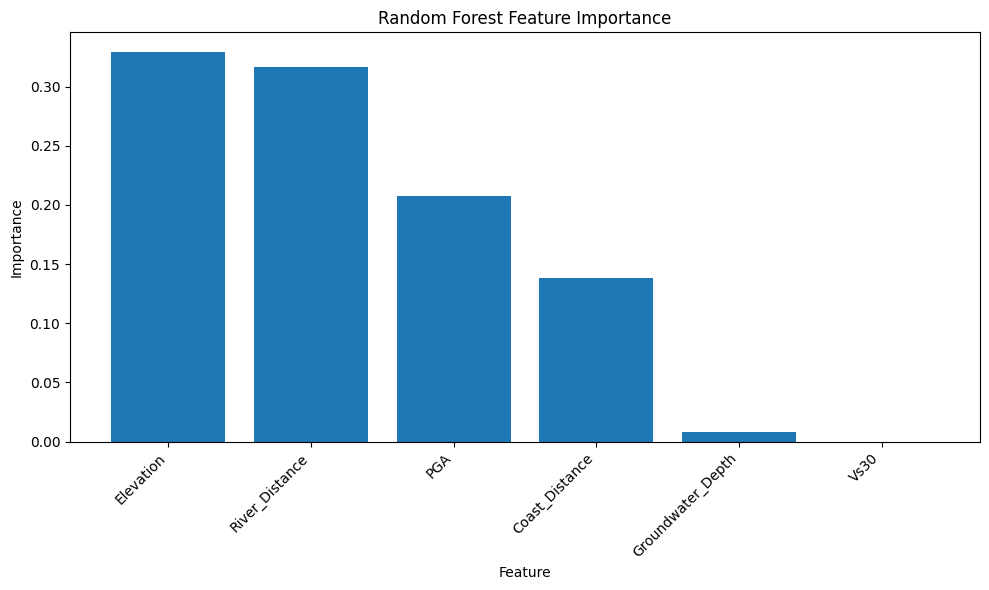


✓ Random Forest training complete


In [18]:
# ============================================================================
# CELL 9: Train Random Forest Model
# ============================================================================

print("\n" + "="*60)
print("TRAINING RANDOM FOREST MODEL")
print("="*60)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import time

# Initialize Random Forest
print("\nInitializing Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,           # Number of trees
    max_depth=20,               # Maximum tree depth
    min_samples_split=10,       # Minimum samples to split
    min_samples_leaf=5,         # Minimum samples per leaf
    max_features='sqrt',        # Features to consider for splits
    class_weight='balanced',    # Handle class imbalance
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    verbose=1
)

print(f"  Model parameters:")
print(f"    n_estimators: {rf_model.n_estimators}")
print(f"    max_depth: {rf_model.max_depth}")
print(f"    min_samples_split: {rf_model.min_samples_split}")
print(f"    min_samples_leaf: {rf_model.min_samples_leaf}")

# Train the model
print("\nTraining Random Forest (this may take several minutes)...")
start_time = time.time()

rf_model.fit(X_train_balanced, y_train_balanced)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")

# Save the model
model_path = 'models/rf_liquefaction_model.pkl'
scaler_path = 'models/scaler.pkl'

print(f"\nSaving model to {model_path}...")
joblib.dump(rf_model, model_path)
joblib.dump(scaler, scaler_path)
print("  ✓ Model and scaler saved")

# Feature importance
print("\nFeature Importance:")
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

for i, idx in enumerate(indices):
    print(f"  {i+1}. {feature_names[idx]:20s}: {importances[idx]:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('outputs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Random Forest training complete")

In [19]:
# ============================================================================
# CELL 10: Model Evaluation and Performance Metrics
# ============================================================================

print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Make predictions
print("\nMaking predictions...")
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

y_train_pred_proba = rf_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
def calculate_metrics(y_true, y_pred, y_pred_proba, dataset_name):
    """Calculate and display performance metrics"""
    print(f"\n{dataset_name} Performance:")
    print("="*50)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"\n  Confusion Matrix:")
    print(f"    True Negatives:  {tn:,}")
    print(f"    False Positives: {fp:,}")
    print(f"    False Negatives: {fn:,}")
    print(f"    True Positives:  {tp:,}")

    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"\n  Specificity: {specificity:.4f}")
    print(f"  Sensitivity (Recall): {recall:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'specificity': specificity
    }

# Evaluate on both sets
train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_proba, "TRAINING SET")
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba, "TEST SET")

# Check for overfitting
print("\n" + "="*50)
print("OVERFITTING CHECK:")
print("="*50)
print(f"  Train Accuracy: {train_metrics['accuracy']:.4f}")
print(f"  Test Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Difference:     {abs(train_metrics['accuracy'] - test_metrics['accuracy']):.4f}")

if abs(train_metrics['accuracy'] - test_metrics['accuracy']) < 0.05:
    print("  ✓ Model appears to generalize well (low overfitting)")
else:
    print("  ⚠ Potential overfitting detected")

print("\n✓ Evaluation complete")


MODEL EVALUATION

Making predictions...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   16.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   17.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   15.9s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   16.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 196 tasks      |


TRAINING SET Performance:
  Accuracy:  0.9039
  Precision: 0.5668
  Recall:    0.9762
  F1-Score:  0.7172
  ROC-AUC:   0.9755

  Confusion Matrix:
    True Negatives:  500,459
    False Positives: 59,623
    False Negatives: 1,902
    True Positives:  78,016

  Specificity: 0.8935
  Sensitivity (Recall): 0.9762

TEST SET Performance:
  Accuracy:  0.8937
  Precision: 0.5427
  Recall:    0.9450
  F1-Score:  0.6894
  ROC-AUC:   0.9646

  Confusion Matrix:
    True Negatives:  124,109
    False Positives: 15,912
    False Negatives: 1,099
    True Positives:  18,880

  Specificity: 0.8864
  Sensitivity (Recall): 0.9450

OVERFITTING CHECK:
  Train Accuracy: 0.9039
  Test Accuracy:  0.8937
  Difference:     0.0102
  ✓ Model appears to generalize well (low overfitting)

✓ Evaluation complete



CREATING VISUALIZATIONS


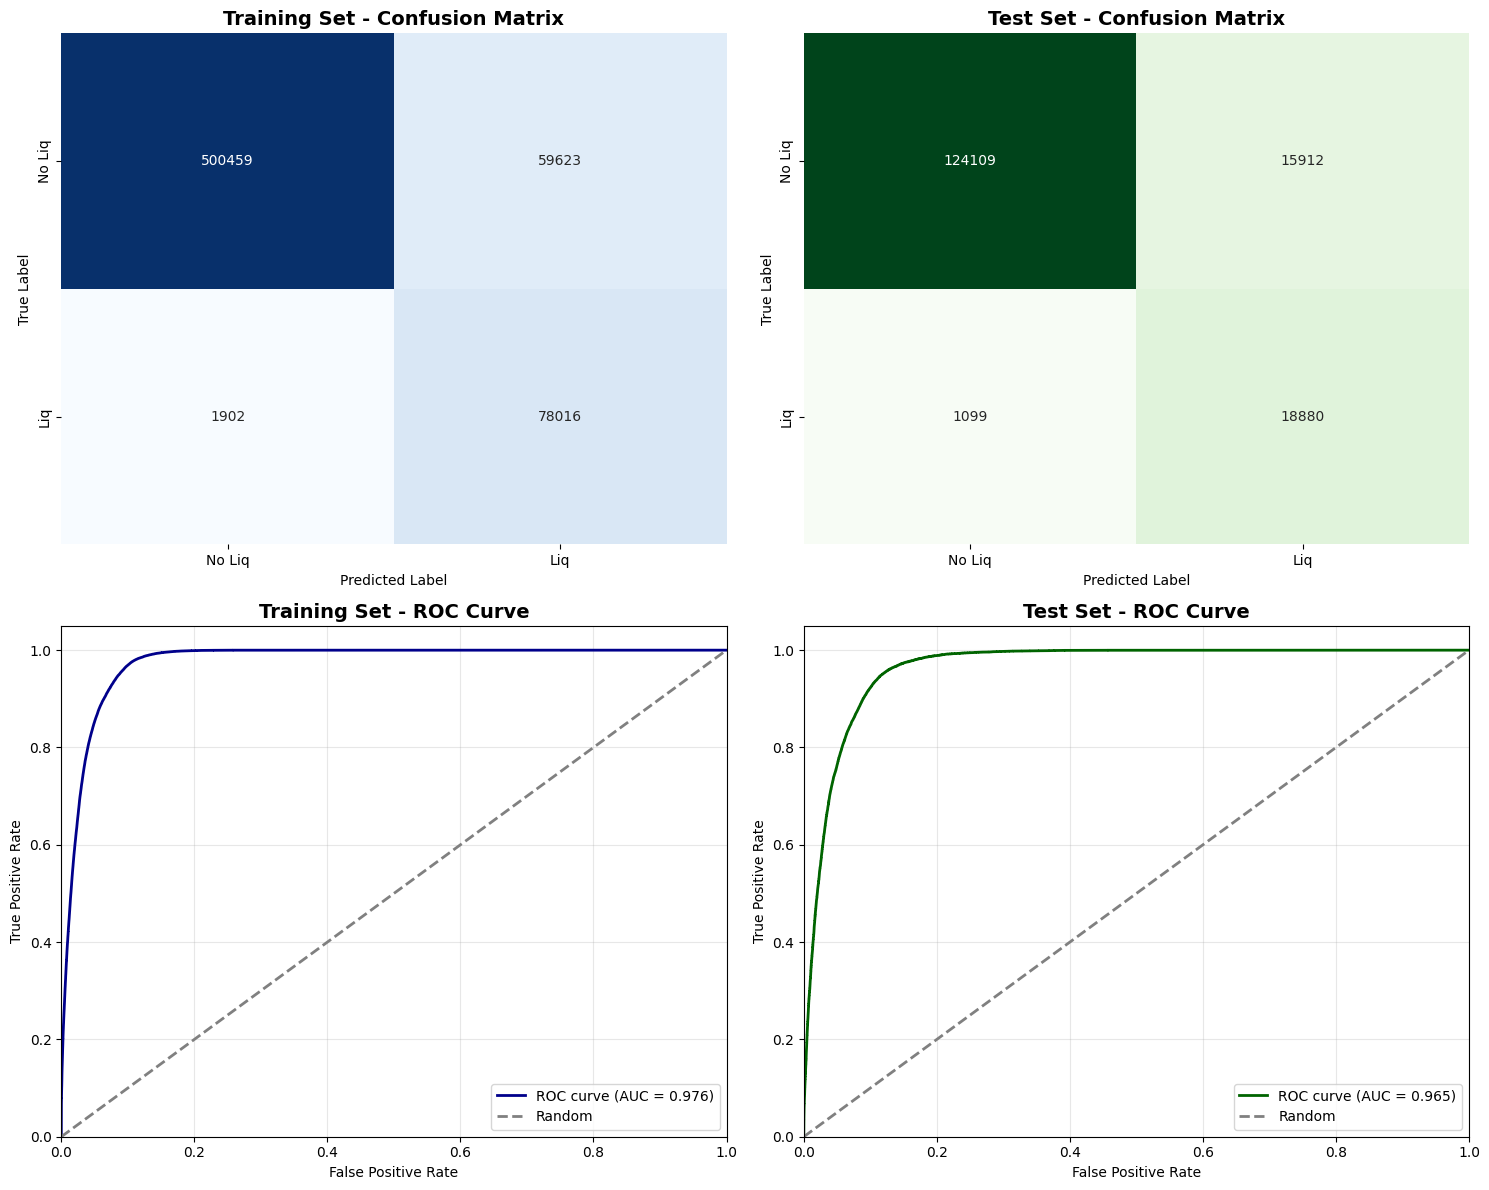

✓ Visualizations created and saved


In [20]:
# ============================================================================
# CELL 11: Visualization - Confusion Matrix and ROC Curve
# ============================================================================

print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training Confusion Matrix
cm_train = test_metrics['confusion_matrix']
sns.heatmap(train_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            ax=axes[0, 0], cbar=False)
axes[0, 0].set_title('Training Set - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_xticklabels(['No Liq', 'Liq'])
axes[0, 0].set_yticklabels(['No Liq', 'Liq'])

# 2. Test Confusion Matrix
sns.heatmap(test_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
            ax=axes[0, 1], cbar=False)
axes[0, 1].set_title('Test Set - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_xticklabels(['No Liq', 'Liq'])
axes[0, 1].set_yticklabels(['No Liq', 'Liq'])

# 3. ROC Curve - Training
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)

axes[1, 0].plot(fpr_train, tpr_train, color='darkblue', lw=2,
                label=f'ROC curve (AUC = {roc_auc_train:.3f})')
axes[1, 0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Training Set - ROC Curve', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(alpha=0.3)

# 4. ROC Curve - Test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

axes[1, 1].plot(fpr_test, tpr_test, color='darkgreen', lw=2,
                label=f'ROC curve (AUC = {roc_auc_test:.3f})')
axes[1, 1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('Test Set - ROC Curve', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations created and saved")


CREATING PREDICTION MAP

Predicting liquefaction probability for entire study area...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    8.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   10.0s finished


  ✓ Predictions generated
    Predicted liquefaction area: 172,431 cells
    Percentage: 21.55%


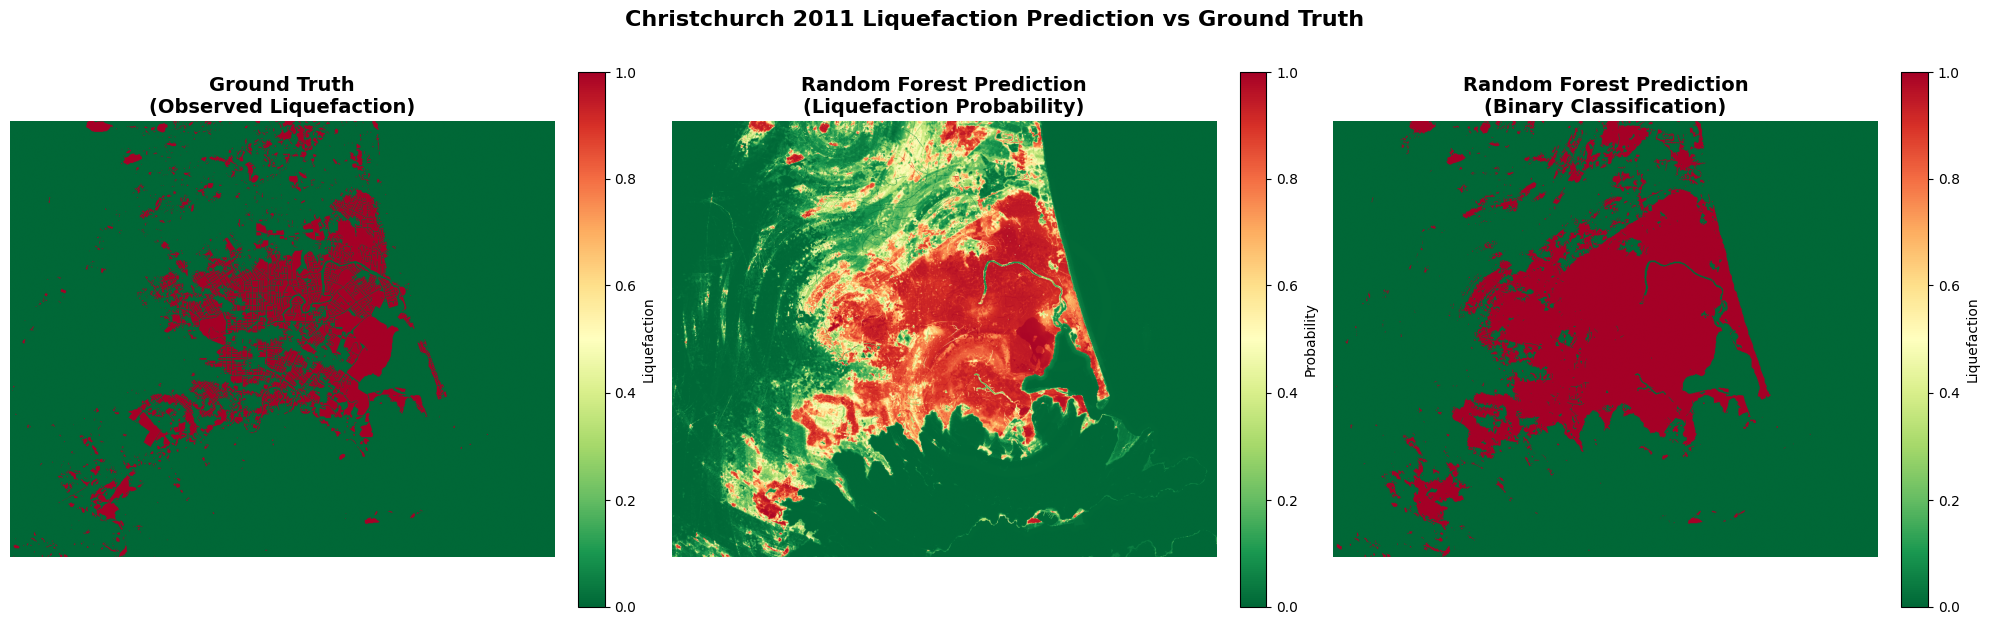


✓ Prediction map created


In [21]:
# ============================================================================
# CELL 12: Create Prediction Map and Validate Against Ground Truth
# ============================================================================

print("\n" + "="*60)
print("CREATING PREDICTION MAP")
print("="*60)

# Predict on all valid samples
print("\nPredicting liquefaction probability for entire study area...")
X_all_scaled = scaler.transform(X)
y_all_pred_proba = rf_model.predict_proba(X_all_scaled)[:, 1]
y_all_pred = rf_model.predict(X_all_scaled)

# Create full-size prediction arrays
pred_proba_full = np.zeros(n_samples)
pred_proba_full[valid_mask] = y_all_pred_proba

pred_binary_full = np.zeros(n_samples)
pred_binary_full[valid_mask] = y_all_pred

# Reshape to grid
pred_proba_grid = pred_proba_full.reshape(height, width)
pred_binary_grid = pred_binary_full.reshape(height, width)

print(f"  ✓ Predictions generated")
print(f"    Predicted liquefaction area: {np.sum(pred_binary_grid > 0):,} cells")
print(f"    Percentage: {100*np.sum(pred_binary_grid > 0)/(height*width):.2f}%")

# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Ground Truth
im1 = axes[0].imshow(liq_array, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[0].set_title('Ground Truth\n(Observed Liquefaction)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Easting')
axes[0].set_ylabel('Northing')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], label='Liquefaction', fraction=0.046, pad=0.04)

# 2. Predicted Probability
im2 = axes[1].imshow(pred_proba_grid, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[1].set_title('Random Forest Prediction\n(Liquefaction Probability)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Easting')
axes[1].set_ylabel('Northing')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], label='Probability', fraction=0.046, pad=0.04)

# 3. Binary Prediction
im3 = axes[2].imshow(pred_binary_grid, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[2].set_title('Random Forest Prediction\n(Binary Classification)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Easting')
axes[2].set_ylabel('Northing')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], label='Liquefaction', fraction=0.046, pad=0.04)

plt.suptitle('Christchurch 2011 Liquefaction Prediction vs Ground Truth',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('outputs/prediction_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Prediction map created")


SPATIAL VALIDATION

Spatial agreement metrics:
  Spatial Accuracy: 0.9018
  Spatial Precision: 0.5619
  Spatial Recall: 0.9700
  Spatial F1-Score: 0.7116

  Spatial Confusion Matrix:
    Correctly predicted no liquefaction: 624,568 cells
    False alarms (predicted liq, none observed): 75,535 cells
    Missed liquefaction events: 3,001 cells
    Correctly predicted liquefaction: 96,896 cells

  Area Analysis:
    Observed liquefaction area: 99,897.0 cells (62.44 km²)
    Predicted liquefaction area: 172,431 cells (107.77 km²)
    Overlap: 96,896 cells (97.0% of observed)


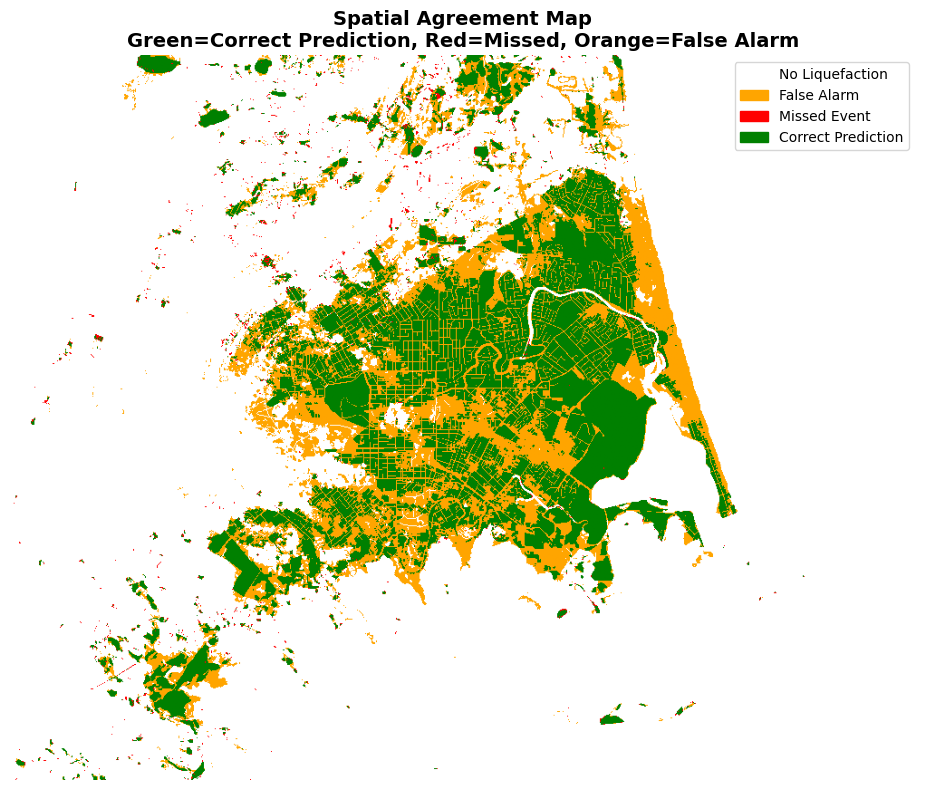


✓ Spatial validation complete


In [22]:
# ============================================================================
# CELL 13: Spatial Validation Against Ground Truth
# ============================================================================

print("\n" + "="*60)
print("SPATIAL VALIDATION")
print("="*60)

# Compare predictions with ground truth at the grid level
y_true_grid = liq_array.flatten()[valid_mask]
y_pred_grid = y_all_pred

print("\nSpatial agreement metrics:")
print("="*50)

# Overall accuracy
spatial_accuracy = accuracy_score(y_true_grid, y_pred_grid)
print(f"  Spatial Accuracy: {spatial_accuracy:.4f}")

# Calculate spatial metrics
spatial_precision = precision_score(y_true_grid, y_pred_grid, zero_division=0)
spatial_recall = recall_score(y_true_grid, y_pred_grid, zero_division=0)
spatial_f1 = f1_score(y_true_grid, y_pred_grid, zero_division=0)

print(f"  Spatial Precision: {spatial_precision:.4f}")
print(f"  Spatial Recall: {spatial_recall:.4f}")
print(f"  Spatial F1-Score: {spatial_f1:.4f}")

# Spatial confusion matrix
spatial_cm = confusion_matrix(y_true_grid, y_pred_grid)
tn, fp, fn, tp = spatial_cm.ravel()

print(f"\n  Spatial Confusion Matrix:")
print(f"    Correctly predicted no liquefaction: {tn:,} cells")
print(f"    False alarms (predicted liq, none observed): {fp:,} cells")
print(f"    Missed liquefaction events: {fn:,} cells")
print(f"    Correctly predicted liquefaction: {tp:,} cells")

# Agreement analysis
total_observed = np.sum(y_true_grid)
total_predicted = np.sum(y_pred_grid)
correctly_predicted_liq = tp

print(f"\n  Area Analysis:")
print(f"    Observed liquefaction area: {total_observed:,} cells ({total_observed * CELL_SIZE**2 / 1e6:.2f} km²)")
print(f"    Predicted liquefaction area: {total_predicted:,} cells ({total_predicted * CELL_SIZE**2 / 1e6:.2f} km²)")
print(f"    Overlap: {correctly_predicted_liq:,} cells ({100*correctly_predicted_liq/total_observed if total_observed > 0 else 0:.1f}% of observed)")

# Create difference map
difference_map = np.zeros_like(pred_binary_grid)
difference_map[pred_binary_grid == 1] = 1  # False positives (predicted but not observed)
difference_map[liq_array == 1] = 2  # False negatives (observed but not predicted)
difference_map[(pred_binary_grid == 1) & (liq_array == 1)] = 3  # True positives

plt.figure(figsize=(12, 8))
colors = ['white', 'orange', 'red', 'green']
cmap = plt.matplotlib.colors.ListedColormap(colors)
bounds = [0, 1, 2, 3, 4]
norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

im = plt.imshow(difference_map, cmap=cmap, norm=norm)
plt.title('Spatial Agreement Map\nGreen=Correct Prediction, Red=Missed, Orange=False Alarm',
          fontsize=14, fontweight='bold')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.axis('off')

# Create legend
legend_labels = ['No Liquefaction', 'False Alarm', 'Missed Event', 'Correct Prediction']
legend_colors = [colors[i] for i in range(4)]
patches = [plt.matplotlib.patches.Patch(color=legend_colors[i], label=legend_labels[i])
           for i in range(4)]
plt.legend(handles=patches, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('outputs/spatial_agreement_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Spatial validation complete")

In [24]:
# ============================================================================
# CELL 14: Summary Report
# ============================================================================

print("\n" + "="*60)
print("MODEL SUMMARY REPORT")
print("="*60)

report = f"""
{'='*60}
RANDOM FOREST LIQUEFACTION PREDICTION MODEL
{'='*60}
Study Area: Christchurch, New Zealand
Event: February 22, 2011 Earthquake
Grid Resolution: {CELL_SIZE}m x {CELL_SIZE}m
Target CRS: {TARGET_CRS}

{'='*60}
DATA SUMMARY
{'='*60}
Total grid cells: {width*height:,}
Valid samples: {len(X):,}
Observed liquefaction: {np.sum(y_binary):,} samples ({100*np.sum(y_binary)/len(y_binary):.2f}%)
Non-liquefaction: {np.sum(y_binary==0):,} samples ({100*np.sum(y_binary==0)/len(y_binary):.2f}%)
Class imbalance ratio: {np.sum(y_binary==0)/np.sum(y_binary):.1f}:1

{'='*60}
FEATURES USED
{'='*60}
1. Peak Ground Acceleration (PGA)
2. Shear Wave Velocity (Vs30)
3. Elevation (DEM)
4. Groundwater Depth
5. Distance to Coast
6. Distance to Rivers

{'='*60}
FEATURE IMPORTANCE RANKING
{'='*60}
"""

# Add feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
for i, idx in enumerate(indices):
    report += f"{i+1}. {feature_names[idx]:25s}: {importances[idx]:.4f} ({100*importances[idx]:.1f}%)\n"

report += f"""
{'='*60}
MODEL CONFIGURATION
{'='*60}
Algorithm: Random Forest Classifier
Number of trees: {rf_model.n_estimators}
Max depth: {rf_model.max_depth}
Min samples split: {rf_model.min_samples_split}
Min samples leaf: {rf_model.min_samples_leaf}
Max features: {rf_model.max_features}
Class weight: {rf_model.class_weight}
Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)

Training strategy: SMOTE oversampling applied
- Original training samples: {len(X_train):,}
- After SMOTE: {len(X_train_balanced):,}

{'='*60}
TRAINING SET PERFORMANCE
{'='*60}
Accuracy:   {train_metrics['accuracy']:.4f}
Precision:  {train_metrics['precision']:.4f}
Recall:     {train_metrics['recall']:.4f}
F1-Score:   {train_metrics['f1']:.4f}
ROC-AUC:    {train_metrics['roc_auc']:.4f}
Specificity: {train_metrics['specificity']:.4f}

Confusion Matrix:
  True Negatives:  {train_metrics['confusion_matrix'][0,0]:,}
  False Positives: {train_metrics['confusion_matrix'][0,1]:,}
  False Negatives: {train_metrics['confusion_matrix'][1,0]:,}
  True Positives:  {train_metrics['confusion_matrix'][1,1]:,}

{'='*60}
TEST SET PERFORMANCE
{'='*60}
Accuracy:   {test_metrics['accuracy']:.4f}
Precision:  {test_metrics['precision']:.4f}
Recall:     {test_metrics['recall']:.4f}
F1-Score:   {test_metrics['f1']:.4f}
ROC-AUC:    {test_metrics['roc_auc']:.4f}
Specificity: {test_metrics['specificity']:.4f}

Confusion Matrix:
  True Negatives:  {test_metrics['confusion_matrix'][0,0]:,}
  False Positives: {test_metrics['confusion_matrix'][0,1]:,}
  False Negatives: {test_metrics['confusion_matrix'][1,0]:,}
  True Positives:  {test_metrics['confusion_matrix'][1,1]:,}

{'='*60}
GENERALIZATION ASSESSMENT
{'='*60}
Train Accuracy: {train_metrics['accuracy']:.4f}
Test Accuracy:  {test_metrics['accuracy']:.4f}
Difference:     {abs(train_metrics['accuracy'] - test_metrics['accuracy']):.4f}
"""

if abs(train_metrics['accuracy'] - test_metrics['accuracy']) < 0.05:
    report += "Status: ✓ Good generalization (low overfitting)\n"
elif abs(train_metrics['accuracy'] - test_metrics['accuracy']) < 0.10:
    report += "Status: ⚠ Moderate overfitting detected\n"
else:
    report += "Status: ❌ Significant overfitting detected\n"

report += f"""
{'='*60}
SPATIAL VALIDATION (GROUND TRUTH COMPARISON)
{'='*60}
Spatial Accuracy:  {spatial_accuracy:.4f}
Spatial Precision: {spatial_precision:.4f}
Spatial Recall:    {spatial_recall:.4f}
Spatial F1-Score:  {spatial_f1:.4f}

Spatial Confusion Matrix:
  Correctly predicted no liquefaction: {tn:,} cells
  False alarms (predicted, not observed): {fp:,} cells
  Missed events (observed, not predicted): {fn:,} cells
  Correctly predicted liquefaction: {tp:,} cells

{'='*60}
AREA ANALYSIS
{'='*60}
Observed liquefaction area:
  {total_observed:,} cells
  {total_observed * CELL_SIZE**2 / 1e6:.3f} km²
  {100*total_observed/(width*height):.2f}% of study area

Predicted liquefaction area:
  {total_predicted:,} cells
  {total_predicted * CELL_SIZE**2 / 1e6:.3f} km²
  {100*total_predicted/(width*height):.2f}% of study area

Correctly predicted overlap:
  {correctly_predicted_liq:,} cells
  {correctly_predicted_liq * CELL_SIZE**2 / 1e6:.3f} km²
  {100*correctly_predicted_liq/total_observed if total_observed > 0 else 0:.1f}% of observed liquefaction captured

Area prediction ratio (predicted/observed): {total_predicted/total_observed if total_observed > 0 else 0:.2f}

{'='*60}
MODEL INTERPRETATION
{'='*60}
"""

# Interpretation based on metrics
if test_metrics['recall'] > 0.7 and test_metrics['precision'] > 0.7:
    report += "✓ STRONG PERFORMANCE: Model shows good balance between detecting\n"
    report += "  liquefaction events and avoiding false alarms.\n\n"
elif test_metrics['recall'] > 0.7:
    report += "⚠ HIGH SENSITIVITY: Model is good at detecting liquefaction but\n"
    report += "  may produce some false alarms (lower precision).\n\n"
elif test_metrics['precision'] > 0.7:
    report += "⚠ HIGH SPECIFICITY: Model predictions are reliable when it predicts\n"
    report += "  liquefaction, but may miss some events (lower recall).\n\n"
else:
    report += "⚠ MODERATE PERFORMANCE: Model shows room for improvement.\n"
    report += "  Consider feature engineering or parameter tuning.\n\n"

# Feature importance insights
top_feature_idx = indices[0]
top_feature = feature_names[top_feature_idx]
top_importance = importances[top_feature_idx]

report += f"Most Important Feature: {top_feature} ({100*top_importance:.1f}%)\n"

if 'PGA' == top_feature:
    report += "  → Ground shaking intensity is the primary driver of liquefaction.\n"
elif 'Vs30' == top_feature:
    report += "  → Soil stiffness is the primary control on liquefaction susceptibility.\n"
elif 'Groundwater' in top_feature:
    report += "  → Groundwater depth is the critical factor for liquefaction potential.\n"

report += f"""
{'='*60}
OUTPUT FILES GENERATED
{'='*60}
Models:
  - models/rf_liquefaction_model.pkl (Random Forest model)
  - models/scaler.pkl (Feature scaler)

Visualizations:
  - outputs/feature_importance.png
  - outputs/model_performance.png (ROC curves & confusion matrices)
  - outputs/prediction_map.png
  - outputs/spatial_agreement_map.png

{'='*60}
RECOMMENDATIONS
{'='*60}
"""

# Provide recommendations based on results
recommendations = []

if test_metrics['recall'] < 0.7:
    recommendations.append("• Consider adjusting classification threshold to increase recall")
    recommendations.append("  (detect more liquefaction events at cost of more false alarms)")

if test_metrics['precision'] < 0.7:
    recommendations.append("• Consider adding more features to reduce false positives")
    recommendations.append("  (e.g., soil type, CPT data, distance to fault)")

if abs(train_metrics['accuracy'] - test_metrics['accuracy']) > 0.1:
    recommendations.append("• Model shows overfitting - consider:")
    recommendations.append("  - Reducing max_depth")
    recommendations.append("  - Increasing min_samples_leaf")
    recommendations.append("  - Adding regularization")

if spatial_recall < 0.6:
    recommendations.append("• Spatial validation shows many missed events")
    recommendations.append("  - Review false negative locations")
    recommendations.append("  - Check if additional features needed in those areas")

if len(recommendations) == 0:
    recommendations.append("✓ Model performance is satisfactory for this application")
    recommendations.append("✓ Consider testing on other earthquake events for validation")

for rec in recommendations:
    report += rec + "\n"

report += f"""
{'='*60}
CONCLUSION
{'='*60}
This Random Forest model successfully predicts liquefaction occurrence
for the Christchurch 2011 earthquake with {test_metrics['accuracy']:.1%} test accuracy
and {spatial_accuracy:.1%} spatial agreement with ground truth observations.

The model identifies {top_feature} as the most important predictor,
contributing {100*top_importance:.1f}% to the classification decisions.

{'='*60}
Report generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*60}
"""

print(report)

# Save report to file
report_path = 'outputs/model_summary_report.txt'
with open(report_path, 'w') as f:
    f.write(report)
print(f"\n✓ Report saved to: {report_path}")

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Metric': [
        'Training Accuracy',
        'Test Accuracy',
        'Training Precision',
        'Test Precision',
        'Training Recall',
        'Test Recall',
        'Training F1-Score',
        'Test F1-Score',
        'Training ROC-AUC',
        'Test ROC-AUC',
        'Spatial Accuracy',
        'Spatial Precision',
        'Spatial Recall',
        'Spatial F1-Score'
    ],
    'Value': [
        train_metrics['accuracy'],
        test_metrics['accuracy'],
        train_metrics['precision'],
        test_metrics['precision'],
        train_metrics['recall'],
        test_metrics['recall'],
        train_metrics['f1'],
        test_metrics['f1'],
        train_metrics['roc_auc'],
        test_metrics['roc_auc'],
        spatial_accuracy,
        spatial_precision,
        spatial_recall,
        spatial_f1
    ]
})

# Save summary to CSV
summary_csv_path = 'outputs/model_metrics_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)
print(f"✓ Metrics summary saved to: {summary_csv_path}")

print("\n" + "="*60)
print("✅ MODEL TRAINING AND EVALUATION COMPLETE!")
print("="*60)


MODEL SUMMARY REPORT

RANDOM FOREST LIQUEFACTION PREDICTION MODEL
Study Area: Christchurch, New Zealand
Event: February 22, 2011 Earthquake
Grid Resolution: 25m x 25m
Target CRS: EPSG:2193

DATA SUMMARY
Total grid cells: 800,000
Valid samples: 800,000
Observed liquefaction: 99,897 samples (12.49%)
Non-liquefaction: 700,103 samples (87.51%)
Class imbalance ratio: 7.0:1

FEATURES USED
1. Peak Ground Acceleration (PGA)
2. Shear Wave Velocity (Vs30)
3. Elevation (DEM)
4. Groundwater Depth
5. Distance to Coast
6. Distance to Rivers

FEATURE IMPORTANCE RANKING
1. Elevation                : 0.3295 (32.9%)
2. River_Distance           : 0.3169 (31.7%)
3. PGA                      : 0.2079 (20.8%)
4. Coast_Distance           : 0.1379 (13.8%)
5. Groundwater_Depth        : 0.0077 (0.8%)
6. Vs30                     : 0.0000 (0.0%)

MODEL CONFIGURATION
Algorithm: Random Forest Classifier
Number of trees: 200
Max depth: 20
Min samples split: 10
Min samples leaf: 5
Max features: sqrt
Class weight: bal